# COVID-19 by Population through July 2020, Exploratory Data Analysis and Modeling

***Matt Paterson, hello@hireMattPaterson.com<br>
In collaboration with:
Eric Laverdiere and Matthew Burrell, Data Science Fellows, General Assembly

## A look at relative risk of contracting, spreading, or coming into contact with the Coronavirus Disease - 2019

This notebook uses data from Google's BigQuery related to total confirmed cases and confirmed deaths from Covid-19 through July 31, 2020 in the United States, as well as US Census Bureau data for the populations of every county in the United States.

In [1]:
# Pull in the python libraries to be used:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import from Scikit-Learn the various modeling libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model    import LinearRegression, LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import PolynomialFeatures, StandardScaler
from sklearn.decomposition   import PCA
from sklearn.pipeline        import Pipeline
from sklearn.cluster         import KMeans
from sklearn.svm             import LinearSVC

In [2]:
# Pull in the CSV and print the first five rows of the new dataframe

path_to_home = '../'
path_to_data = 'data/BIG-QUERY/'
filename = 'Covid_and_Pop_by_County.csv'

df = pd.read_csv(path_to_home+path_to_data+filename)
df.head()

,Unnamed: 0,population,county_name,state_name,cumulative_confirmed,cumulative_deceased,latitude,longitude
0,"Autauga County, Alabama",55869.0,Autauga County,Alabama,1015.0,21.0,32.536667,-86.648333
1,"Baldwin County, Alabama",223234.0,Baldwin County,Alabama,3101.0,22.0,30.733056,-87.720278
2,"Barbour County, Alabama",24686.0,Barbour County,Alabama,598.0,5.0,31.865833,-85.396111
3,"Bibb County, Alabama",22394.0,Bibb County,Alabama,363.0,2.0,32.997778,-87.126389
4,"Blount County, Alabama",57826.0,Blount County,Alabama,767.0,3.0,33.966667,-86.583333


Due to the way that I use the county_state as the index, we'll need to rename that column and set it as the index for our dataset here

In [3]:
df.rename(columns={'Unnamed: 0': 'county_state', 
                  'cumulative_confirmed': 'positive_tests', 
                  'cumulative_deceased': 'deaths'}, inplace=True)
df.set_index('county_state', inplace=True)
df.head()

,population,county_name,state_name,positive_tests,deaths,latitude,longitude
county_state,,,,,,,
"Autauga County, Alabama",55869.0,Autauga County,Alabama,1015.0,21.0,32.536667,-86.648333
"Baldwin County, Alabama",223234.0,Baldwin County,Alabama,3101.0,22.0,30.733056,-87.720278
"Barbour County, Alabama",24686.0,Barbour County,Alabama,598.0,5.0,31.865833,-85.396111
"Bibb County, Alabama",22394.0,Bibb County,Alabama,363.0,2.0,32.997778,-87.126389
"Blount County, Alabama",57826.0,Blount County,Alabama,767.0,3.0,33.966667,-86.583333


## Create a second DataFrame
We are going to look at the county-level data here, but just in case we want to use a state-level lense later to look at things, we are keeping the state data in tact.  Our model will only want to use numeric data, so we can create a features list without the county_name or state_name columns.

In [4]:
cnty = df.drop(columns=['county_name'])
cnty.shape

(3020, 6)

## A quick peek
We only have five columns now. That's not going to give a lot of interesting information considering one of the columns is the total number of deaths, and we don't have the number of people who actually took the test.  The testing number is available at the state level but I cannot yet find it at the county level. We'll have to enginner some columns in the data, but before we do that, let's look at what we've got.

In [5]:
cnty.head()

,population,state_name,positive_tests,deaths,latitude,longitude
county_state,,,,,,
"Autauga County, Alabama",55869.0,Alabama,1015.0,21.0,32.536667,-86.648333
"Baldwin County, Alabama",223234.0,Alabama,3101.0,22.0,30.733056,-87.720278
"Barbour County, Alabama",24686.0,Alabama,598.0,5.0,31.865833,-85.396111
"Bibb County, Alabama",22394.0,Alabama,363.0,2.0,32.997778,-87.126389
"Blount County, Alabama",57826.0,Alabama,767.0,3.0,33.966667,-86.583333


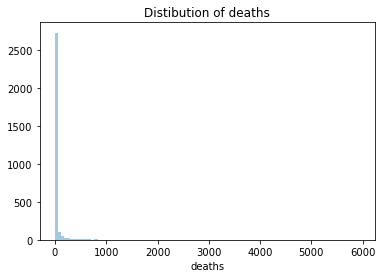

In [6]:
sns.distplot(cnty.deaths, kde=False, bins = 100)

#plt.xticks(labels='Deaths')=list(range(0,5000,100))
plt.title("Distibution of deaths");

We see that the majority of counties have fewer than 100 deaths.

In [7]:
cnty.corr()

,population,positive_tests,deaths,latitude,longitude
population,1.000000,0.925524,0.720162,-0.057852,-0.016301
positive_tests,0.925524,1.000000,0.792381,-0.090185,0.022816
deaths,0.720162,0.792381,1.000000,0.006767,0.113104
latitude,-0.057852,-0.090185,0.006767,1.000000,-0.168084
longitude,-0.016301,0.022816,0.113104,-0.168084,1.000000


As is intuitive, population has a very strong correlation with the number of people that have tested positive for Coronavirus Disease as well as those that have died from it.  We also see that lattitude has a slightly inverse correlation with positive cases, suggesting that the further north you go the less likely you are to test positive for the diesease, yet has less than a 1% correlation to the number of deaths.

The below heatmap represents this visually

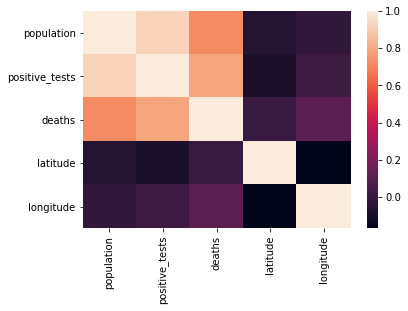

In [8]:
sns.heatmap(cnty.corr());

## Feature Engineering
Let's create a few intuitive columns, such as the number of deaths per 100K people, and the percentage of deaths in a population.

In [9]:
cnty['deaths_per_100K'] = cnty.deaths / (cnty.population / 100_000)

In [10]:
deadliest = cnty[cnty.deaths_per_100K > 200].sort_values('deaths_per_100K', ascending=False)
deadliest

,population,state_name,positive_tests,deaths,latitude,longitude,deaths_per_100K
county_state,,,,,,,
"Hancock County, Georgia",8457.0,Georgia,280.0,34.0,33.270000,-83.000000,402.033818
"Randolph County, Georgia",6778.0,Georgia,257.0,26.0,31.760000,-84.760000,383.593981
"Terrell County, Georgia",8531.0,Georgia,289.0,30.0,31.780000,-84.440000,351.658657
"McKinley County, New Mexico",71367.0,New Mexico,3988.0,219.0,35.580000,-108.260000,306.864517
"Early County, Georgia",10190.0,Georgia,342.0,31.0,31.330000,-84.910000,304.219823
"Neshoba County, Mississippi",29118.0,Mississippi,1186.0,87.0,32.750000,-89.120000,298.784257
"Bronx County, New York",1418207.0,New York,49659.0,3910.0,40.846760,-73.873207,275.700233
"Holmes County, Mississippi",17010.0,Mississippi,825.0,46.0,33.120000,-90.090000,270.429159
"Lowndes County, Alabama",9726.0,Alabama,558.0,26.0,32.150000,-86.650000,267.324697


## Well this is interesting:
***Intuitively, I would think that the deadliest places were New York, Northern New Jersey, Eastern Massachusetts, and Los Angeles based on prior reporting of COVID-19.  Maybe even Detroit.  But according to the deaths per 100K, four out of the five deadliest counties are in Georgia.***

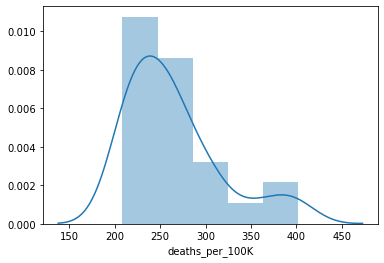

In [11]:
sns.distplot(deadliest['deaths_per_100K']);

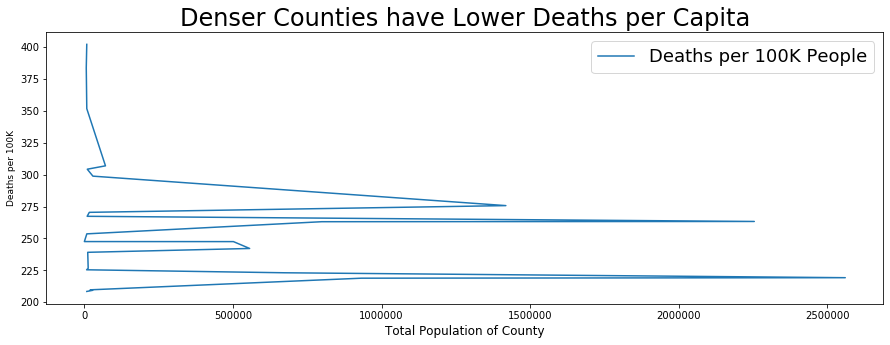

In [12]:
plt.figure(figsize=(15, 5))

plt.plot(deadliest.population,
        deadliest.deaths_per_100K,
        label = 'Deaths per 100K People');

plt.xlabel('Total Population of County', fontsize=12)
plt.ylabel('Deaths per 100K', fontsize=9)
plt.title('Denser Counties have Lower Deaths per Capita', fontsize=24)
plt.legend(loc = 'upper right', fontsize = 18);

In [13]:
deadliest.shape

(24, 7)

In [14]:
cnty.shape

(3020, 7)

## Linear Regression Model
### Predict the number of deaths per 100K. We will use this later to cluster the counties into five levels of danger zones

1. Quick and dirty linear regression model using only the rows we have
2. Use PolynomialFeatures to create some crazy feautres and try a Linear Regression model
3. Use a PCA before the linear regression

#### Make sure that all of our data is numeric and that there are no null values

In [15]:
cnty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3020 entries, Autauga County, Alabama to Weston County, Wyoming
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   population       3020 non-null   float64
 1   state_name       3020 non-null   object 
 2   positive_tests   3020 non-null   float64
 3   deaths           3020 non-null   float64
 4   latitude         3020 non-null   float64
 5   longitude        3020 non-null   float64
 6   deaths_per_100K  3020 non-null   float64
dtypes: float64(6), object(1)
memory usage: 188.8+ KB


In [16]:
features = ['population', 'positive_tests', 'deaths', 'latitude', 'longitude']

X = cnty[features]
y = cnty['deaths_per_100K']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, 
                                                    random_state=42)

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.2612870725295282

In [18]:
lr.score(X_test, y_test)

0.20064141433982496

#### Massive disapointment. It looks like the field we are trying to predict is also a function of two of the columns, so also, that is not going to be a model we need a linear regression to predict if the input columns are involved in the model.

In [19]:
# Take a quick look at a different dataset for Covid:
df_2 = pd.read_csv(path_to_home+path_to_data+'2020-08-01-county.csv')
df_2.shape

(3220, 14)

In [20]:
df_2.columns

Index(['province_state', 'country_region', 'date', 'latitude', 'longitude',
       'sub_region1_name', 'location_geom', 'confirmed', 'deaths', 'recovered',
       'active', 'fips', 'admin_2', 'combined_key'],
      dtype='object')

In [21]:
# That's the same data that we are already working 
# with. It doesn't lend well to machine learning

## Use the Polynomial Functions


In [22]:
# Borrowing this from the lesson on PCA:
# To get a better result, we're going to make more features.
pf = PolynomialFeatures(degree = 2)

# Fit and transform our X data using Polynomial Features.
X_new = pf.fit_transform(X)

# How many features do we have now?
print(X_new.shape)

# How many features did we start out with?
print(X.shape)

(3020, 21)
(3020, 5)


In [23]:
# Try a simple LR on this new set:

X_train, X_test, y_train, y_test = train_test_split(X_new, y, 
                                                    test_size=.2, 
                                                    random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
print("Training Score: ", lr.score(X_train, y_train))
print("Testing Score: ", lr.score(X_test, y_test))

Training Score:  0.39114339859790476
Testing Score:  -0.1700418422962584


## Try PCA
The result of only using polynomials was a better (though still bad) training score and a horrible testing score.  So re-run it using a higher degree polynomial features and then use the PCA to reduce dimensionality.

In [24]:
pf = PolynomialFeatures(degree = 4)
X_new = pf.fit_transform(X)
print(X_new.shape)
print(X.shape)

(3020, 126)
(3020, 5)


In [25]:
# Again to borrow from the PCA lesson...give credit down this page for that
X_train, X_test, y_train, y_test = train_test_split(X_new, y, 
                                                    test_size=.2, 
                                                    random_state=42)

# Instantiate our StandardScaler, though this will adversely affect lat/long data
ss = StandardScaler()

# Standardize X_train.
X_train = ss.fit_transform(X_train)

# Standardize X_test.
X_test = ss.transform(X_test)


In [26]:
pca = PCA(n_components=10, random_state = 42)
pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

In [27]:
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 20 components): {np.round(var_exp[:20], 4)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:20], 4)}')

Explained variance (first 20 components): [0.6751 0.1007 0.0819 0.0697 0.0292 0.0187 0.009  0.0062 0.0035 0.0014]

Cumulative explained variance (first 20 components): [0.6751 0.7758 0.8577 0.9274 0.9566 0.9753 0.9843 0.9905 0.994  0.9954]


In [28]:
# Instantiate linear regression model.
lm = LinearRegression()

# Transform Z_train and Z_test.
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

# Fit on Z_train.
lm.fit(Z_train, y_train)

# Score on training and testing sets.
print(f'Training Score: {round(lm.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(lm.score(Z_test, y_test),4)}')

Training Score: 0.3097
Testing Score: -2.9546


That is a shit score. This model did not get any better through this exercise. That is probably due to having bad data all along.

## Try Kmeans.  Ideally we'd have several risk factors, such as hospitalizations, postive testing percentages, total deaths, but for now try a quick and dirty Kmeans


#### When we plot the latitude and logitude, we find that the distribution of severity is pretty vast.  Out of 

In [29]:
cnty.columns

Index(['population', 'state_name', 'positive_tests', 'deaths', 'latitude',
       'longitude', 'deaths_per_100K'],
      dtype='object')

<Figure size 2592x432 with 0 Axes>

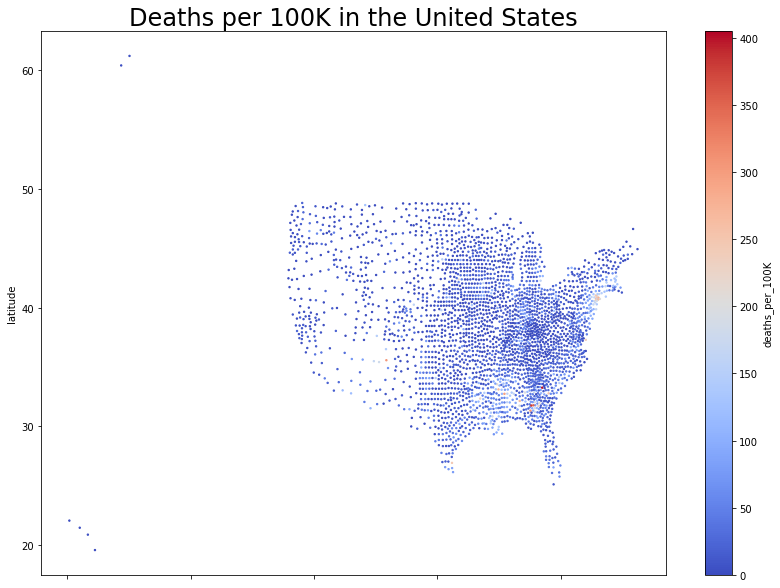

In [30]:
# Where are the deadliest places? - From Riley's Transfer Learning Lecture
# cmap="RdYlGn"
plt.figure(figsize=(36, 6)); # This doesn't seem to change the dimensions of the map
cnty.plot(kind="scatter", x="longitude", y="latitude", c="deaths_per_100K",
         cmap="coolwarm", figsize=(14, 10), s=2, vmin=405, vmax=0);
plt.title("Deaths per 100K in the United States", fontsize=24);

<Figure size 2592x432 with 0 Axes>

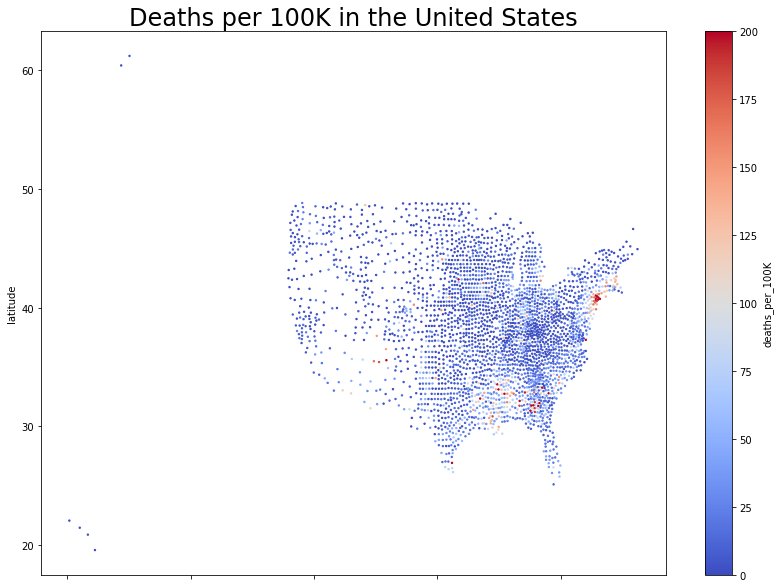

In [31]:
# What if we weight the colormap, displaying all of the most deadliest 50 percentiles
# above the red?
plt.figure(figsize=(36, 6)); # This doesn't seem to change the dimensions of the map
cnty.plot(kind="scatter", x="longitude", y="latitude", c="deaths_per_100K",
         cmap="coolwarm", figsize=(14, 10), s=2, vmin=200, vmax=0);
plt.title("Deaths per 100K in the United States", fontsize=24);

### Mapping above and a histogram below show that the vast majority of our 3,000 counties have a death rate of less than 50 per 100K people over the last seven months.
**Outside of New York City and Northern New Jersey, se see some shades of red and non-blue (greater than 200 deaths per 100K) in mostly rural areas in states such as Georgia where masks were not mandated and "state reopenings" (opening close-contact businesses such as hair and nail salons, barber shops, and gyms) happened as early as April 24, 2020.**

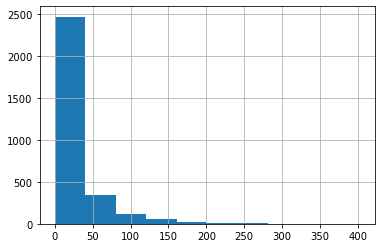

In [32]:
cnty['deaths_per_100K'].hist();

<Figure size 2592x432 with 0 Axes>

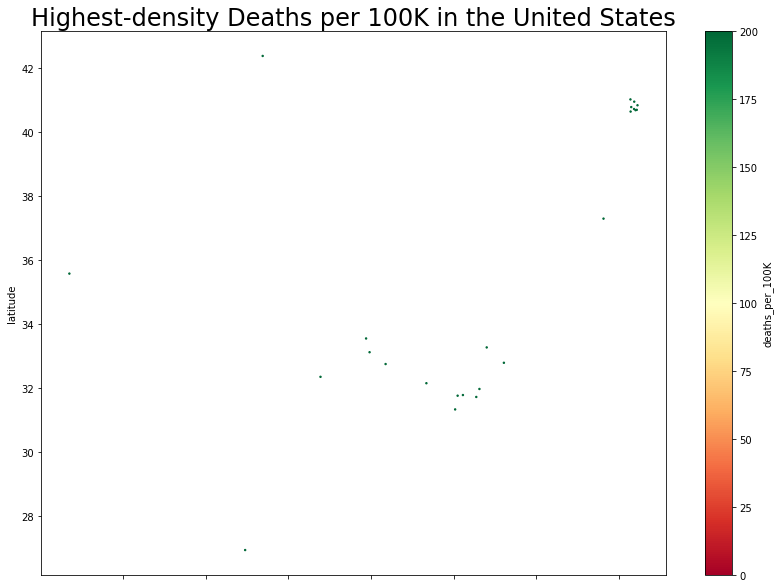

In [33]:
# Where are the highly prices houses? - From Riley's Transfer Learning Lecture
# cmap="RdYlGn"
plt.figure(figsize=(36, 6)); # This doesn't seem to change the dimensions of the map
deadliest.plot(kind="scatter", x="longitude", y="latitude", c="deaths_per_100K",
         cmap="RdYlGn", figsize=(14, 10), s=2, vmin=200, vmax=0);
plt.title("Highest-density Deaths per 100K in the United States", fontsize=24);

# Seek help on this map to:
#    1. Make each dot larger and bolder and richer in color
#    2. Overlay this graph on an outline of the lower 48 contiguous states

## What if we amplify the deaths column and call it a death-risk index?

In [34]:
dri = cnty
dri['death_risk_index'] = dri.deaths_per_100K**2
dri.columns

Index(['population', 'state_name', 'positive_tests', 'deaths', 'latitude',
       'longitude', 'deaths_per_100K', 'death_risk_index'],
      dtype='object')

In [35]:
dri.head()

,population,state_name,positive_tests,deaths,latitude,longitude,deaths_per_100K,death_risk_index
county_state,,,,,,,,
"Autauga County, Alabama",55869.0,Alabama,1015.0,21.0,32.536667,-86.648333,37.587929,1412.852399
"Baldwin County, Alabama",223234.0,Alabama,3101.0,22.0,30.733056,-87.720278,9.855130,97.123579
"Barbour County, Alabama",24686.0,Alabama,598.0,5.0,31.865833,-85.396111,20.254395,410.240525
"Bibb County, Alabama",22394.0,Alabama,363.0,2.0,32.997778,-87.126389,8.930964,79.762112
"Blount County, Alabama",57826.0,Alabama,767.0,3.0,33.966667,-86.583333,5.187978,26.915113


<Figure size 2592x432 with 0 Axes>

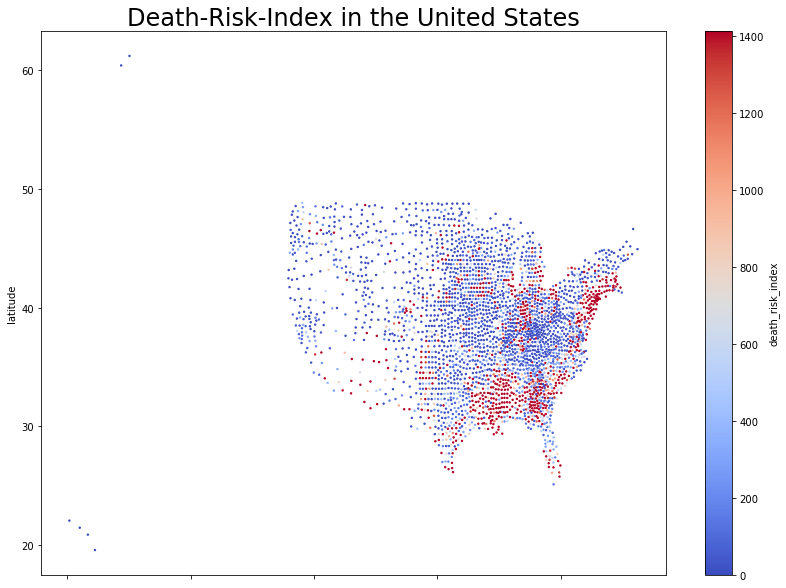

In [36]:
# Where are the highly prices houses? - From Riley's Transfer Learning Lecture
# cmap="RdYlGn"
plt.figure(figsize=(36, 6)); # This doesn't seem to change the dimensions of the map
dri.plot(kind="scatter", x="longitude", y="latitude", c="death_risk_index",
         cmap="coolwarm", figsize=(14, 10), s=2, 
         vmin=dri.quantile(q=.8)[6], 
         vmax=dri.quantile(q=.2)[6]);
plt.title("Death-Risk-Index in the United States", fontsize=24);

## Now look at this index in just the lower 48

In [37]:
dri.sort_values(by='state_name', ascending=True).groupby('state_name').sum()

,population,positive_tests,deaths,latitude,longitude,deaths_per_100K,death_risk_index
state_name,,,,,,,
Alabama,4813673.0,86497.0,1571.0,2169.344318,-5723.262940,3234.366355,3.372410e+05
Alaska,346708.0,2216.0,12.0,121.635000,-301.149167,5.522790,1.748954e+01
Arizona,7278717.0,174108.0,3695.0,505.307500,-1672.361944,1055.942009,1.115876e+05
Arkansas,2992810.0,39845.0,450.0,2584.195000,-6841.740556,1270.262572,5.648887e+04
California,39512223.0,502273.0,9222.0,2194.525556,-7002.633889,688.049423,2.497498e+04
Colorado,5757330.0,46948.0,1841.0,2453.378100,-6648.397072,1110.828711,6.231931e+04
Connecticut,3565287.0,49567.0,4432.0,332.770000,-581.180000,725.781919,8.715288e+04
Delaware,973764.0,14569.0,585.0,117.360000,-226.480000,192.095899,1.279095e+04
District of Columbia,705749.0,12126.0,585.0,38.895000,-77.036667,82.890659,6.870861e+03


In [38]:
dri_low = dri[(dri.state_name != 'Alaska') & (dri.state_name != 'Hawaii')]

<Figure size 1440x720 with 0 Axes>

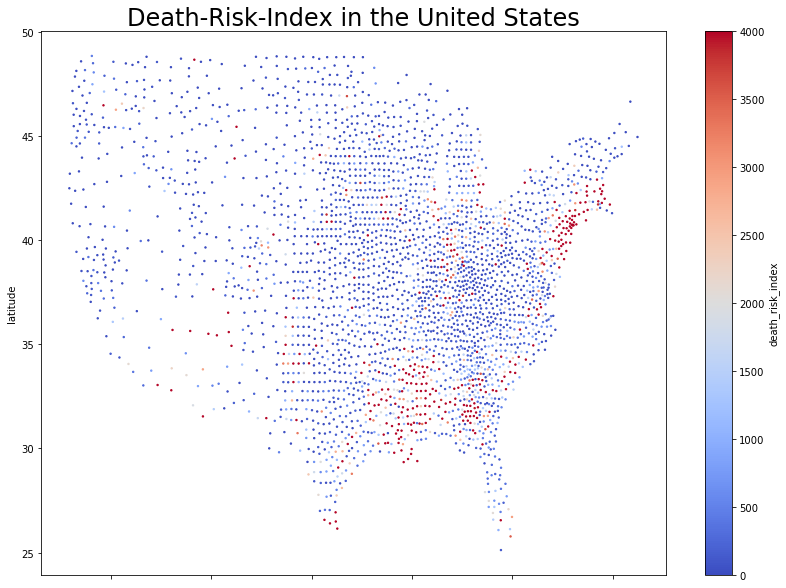

In [39]:
# Where are the deadliest counties? - From Riley's Transfer Learning Lecture
# cmap="RdYlGn"
plt.figure(figsize=(20, 10)); # This doesn't seem to change the dimensions of the map
dri_low.plot(kind="scatter", x="longitude", y="latitude", c="death_risk_index",
         cmap="coolwarm", figsize=(14, 10), s=2, vmin=4000, vmax=0);
plt.title("Death-Risk-Index in the United States", fontsize=24);

In [40]:
dri.describe().T

,count,mean,std,min,25%,50%,75%,max
population,3020.0,106051.094371,338999.675628,404.000000,11384.2500,26259.500000,68151.000000,1.003911e+07
positive_tests,3020.0,1467.169868,6621.650853,1.000000,51.7500,186.000000,665.500000,1.884810e+05
deaths,3020.0,48.367550,268.121272,0.000000,0.0000,3.000000,15.000000,5.934000e+03
latitude,3020.0,38.276782,4.917586,19.583333,34.6375,38.355000,41.701031,6.121833e+01
longitude,3020.0,-91.869816,11.791548,-159.650000,-98.0225,-90.295000,-83.500000,-6.755033e+01
deaths_per_100K,3020.0,23.913395,38.559396,0.000000,0.0000,9.776015,29.751465,4.020338e+02
death_risk_index,3020.0,2058.185129,8051.842936,0.000000,0.0000,95.570558,885.149794,1.616312e+05


In [41]:
dri.quantile(q=.75)[6]

885.1497939910952

<Figure size 648x432 with 0 Axes>

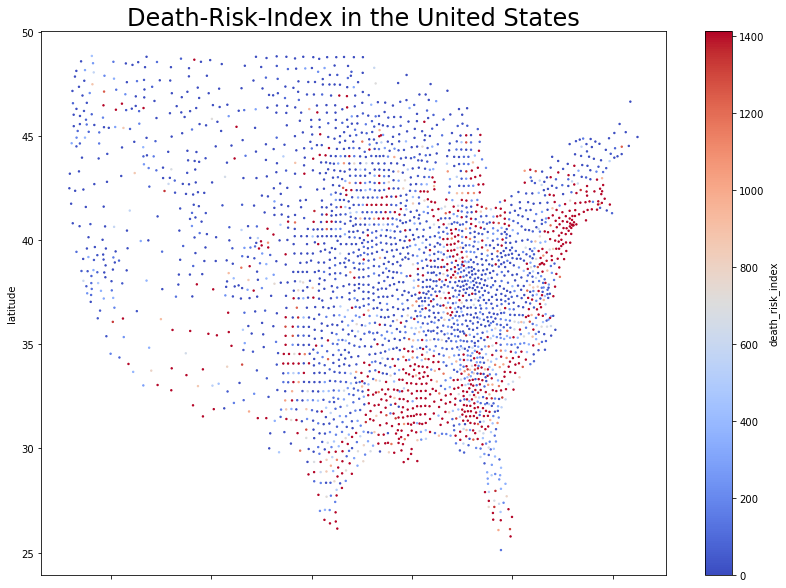

In [42]:
# Where are the deadliest places to live per capita - From Riley's Transfer Learning Lecture
# cmap="RdYlGn"
plt.figure(figsize=(9, 6)); # This doesn't seem to change the dimensions of the map
dri_low.plot(kind="scatter", x="longitude", y="latitude", c="death_risk_index",
         cmap="coolwarm", figsize=(14, 10), s=2, 
             vmin=dri.quantile(q=.8)[6], # This is actually the most RED
             vmax=dri.quantile(q=.2)[6]);                     # This is the most BLUE
plt.title("Death-Risk-Index in the United States", fontsize=24);

<Figure size 648x432 with 0 Axes>

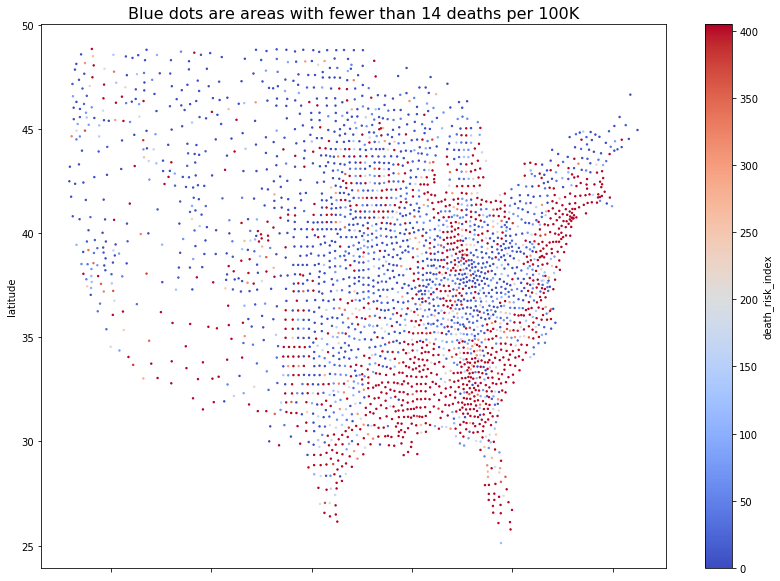

In [43]:
# Where are the deadliest places to live per capita - From Riley's Transfer Learning Lecture
# cmap="RdYlGn"
plt.figure(figsize=(9, 6)); # This doesn't seem to change the dimensions of the map
dri_low.plot(kind="scatter", x="longitude", y="latitude", c="death_risk_index",
         cmap="coolwarm", figsize=(14, 10), s=2, 
             vmin=405, # This is actually the most RED
             vmax=0);                     # This is the most BLUE
plt.title("Blue dots are areas with fewer than 14 deaths per 100K", fontsize=16);

## Clustering this data using Kmeans

### We'll want to run the clustering algorithm twice:
1. Cluster by location geographically into 25 (or best size) regions
2. Cluster by risk index
3. Chart all onto a map

### Pipeline and Scaling
Before using the KMeans algorithm on this data we'll want to scale it.  Let's use a pipeline to do this, dropping out the state names before we run the model

In [44]:
dri_model = dri_low.drop(columns='state_name')
geog_clus = dri_model[['latitude', 'longitude']]
geog_clus.head()

,latitude,longitude
county_state,,
"Autauga County, Alabama",32.536667,-86.648333
"Baldwin County, Alabama",30.733056,-87.720278
"Barbour County, Alabama",31.865833,-85.396111
"Bibb County, Alabama",32.997778,-87.126389
"Blount County, Alabama",33.966667,-86.583333


## One Hundred Geographic Clusters
To allow for more variety in the data, I broke the geography out in to many seperate zones.  It appears that Kmeans separated the areas around the general severity levels too.

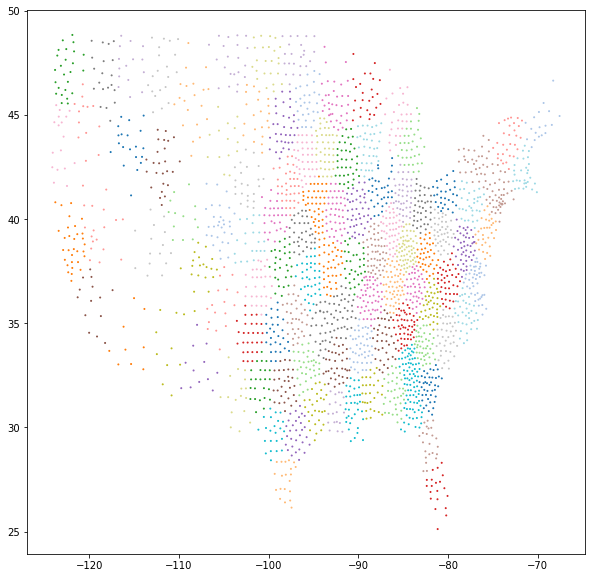

In [45]:
# Use KMeans to cluster geographically and then graph for a look
kmg = KMeans(n_clusters=100)
kmg.fit(geog_clus)
plt.figure(figsize=(10, 10))
plt.scatter(dri_model.longitude, dri_model.latitude, c=kmg.labels_, s=1, cmap="tab20");

Now let's create a new column in the dri_model that deontes the cluster

In [46]:
dri_model['cluster'] = kmg.labels_

In order to plug this model in to a classification model, we'll have to OneHotEncode the new cluster column, drop the latitude/longitude columns, and think about the ther columns in dri_model that are either redundant or misleading, dirty data. In this case, we don't have the total number of people tested per county, so the confirmed case number can be misleading since we have no idea what percentage of people taking the tests actually are testing positive. Further, if we are seeing a postive test rate of over 50%, then it is intuitively obvious that only people who are showing COVID-like symptoms are even being tested. Since we know from anecdotal reports, including the governor of Ohio as of August 6, 2020, people can be completely asypmtomatic and still be carrying this virus.  Thus even if we had the complete testing numbers, they also might not give a good sense of how many in the public are actually infected with this diesase.

In [47]:
dri_model.columns

Index(['population', 'positive_tests', 'deaths', 'latitude', 'longitude',
       'deaths_per_100K', 'death_risk_index', 'cluster'],
      dtype='object')

In [48]:
model_features = ['population', 'deaths', 'deaths_per_100K', 'death_risk_index', 'cluster']
X = dri_model[model_features]
X.columns

Index(['population', 'deaths', 'deaths_per_100K', 'death_risk_index',
       'cluster'],
      dtype='object')

In [49]:
#X = pd.get_dummies(X, columns=['cluster'], drop_first=True)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
population,3014.0,105677.442269,338943.584485,404.0,11342.25,26215.000000,67795.500000,1.003911e+07
deaths,3014.0,48.451559,268.381303,0.0,0.00,3.000000,15.000000,5.934000e+03
deaths_per_100K,3014.0,23.957331,38.585118,0.0,0.00,9.792066,29.806234,4.020338e+02
death_risk_index,3014.0,2062.271053,8059.334567,0.0,0.00,95.884553,888.411992,1.616312e+05
cluster,3014.0,49.671865,28.952944,0.0,24.00,51.000000,74.000000,9.900000e+01


## Scale the data
Prior to popping in to the Kmeans algorithm we should scale the data. Also, since there is so much colinearity and not a lot of features here, we should also think about using PolynomialFeatures and PCA on the data.

In [50]:
ss = StandardScaler()      # transformer
X_ss = ss.fit_transform(X)
km = KMeans(n_clusters = 5, random_state=42)
km.fit(X_ss)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [51]:
km.cluster_centers_

array([[-0.11292226, -0.13113903, -0.24431719, -0.19147595,  0.79975076],
       [-0.08325148, -0.12051239, -0.22650388, -0.18488574, -0.92155156],
       [ 9.03101396, 11.83533681,  2.97828329,  2.93288958,  0.22125975],
       [ 0.6614081 ,  0.72105944,  2.10765063,  1.2892066 ,  0.2461468 ],
       [ 0.2111315 ,  1.40734969,  6.29036186,  8.93885995, -0.18277209]])

## Unscale the results
In order to show the new clusters on the graph, and the centroids, we'll have to unscale the data using the inverse_transform function on the Standard Scaler object

In [52]:
ss.inverse_transform(km.cluster_centers_)     # Unscaling the cluster centers

array([[6.74095180e+04, 1.32621359e+01, 1.45318873e+01, 5.19358323e+02,
        7.28231623e+01],
       [7.74645690e+04, 1.61136537e+01, 1.52191022e+01, 5.72462262e+02,
        2.29946606e+01],
       [3.16617385e+06, 3.22430769e+03, 1.38855677e+02, 2.56954879e+04,
        5.60769231e+01],
       [3.29820282e+05, 2.41938326e+02, 1.05267786e+02, 1.24506946e+04,
        5.67973568e+01],
       [1.77227238e+05, 4.26095238e+02, 2.66631416e+02, 7.40915819e+04,
        4.43809524e+01]])

And create a column in the model dataframe showing the new clusters 

In [53]:
dri_model['hotspot'] = km.labels_


In [54]:
dri_model.hotspot.value_counts(normalize=True)

0    0.478434
1    0.434970
3    0.075315
4    0.006967
2    0.004313
Name: hotspot, dtype: float64

## Graph the new clusters
First combine the lat/long data with the dri_model results, then show a map of the results

In [55]:
resulting = pd.concat([dri_model, dri])


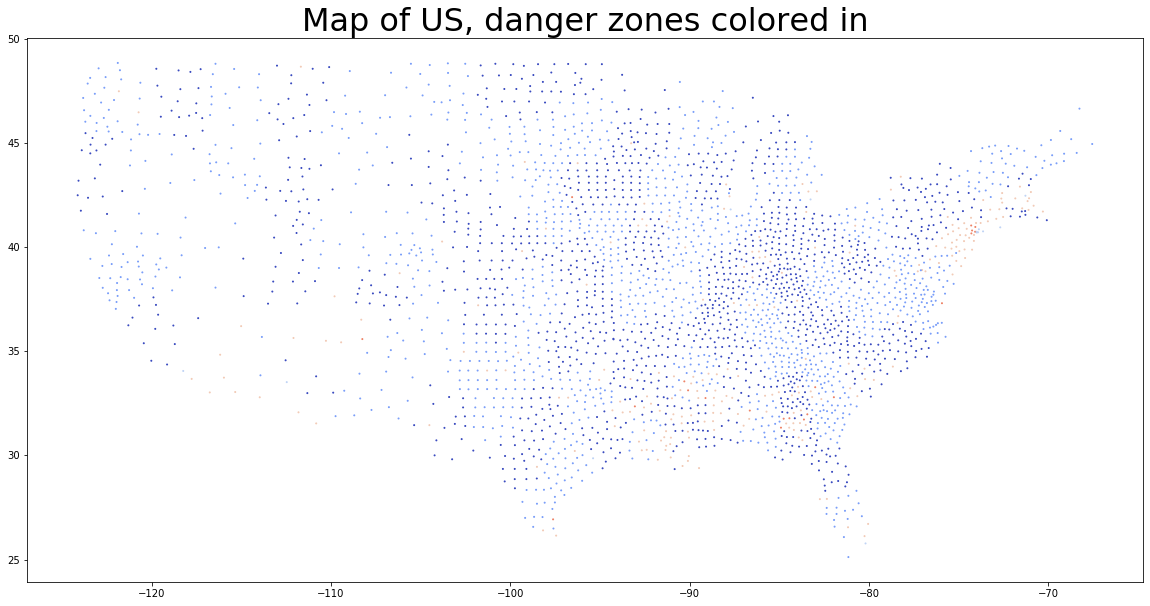

In [56]:
# Plot the new clusters on the goeg data
plt.figure(figsize=(20, 10))
plt.scatter(resulting.longitude, resulting.latitude, c=resulting.hotspot, s=1, 
            vmin=0, vmax=5, cmap="coolwarm");
plt.title('Map of US, danger zones colored in', fontsize=32);

## Create Many geographic zones and then find the average death per 100K for those zones to create an easier-to-visualize map

The first maps didn't do enough to show the relief in the country when it comes to variance in covid dangers.  We'll try now to create a ton of zones and then quantify each by how deadly the zone has been thus far.

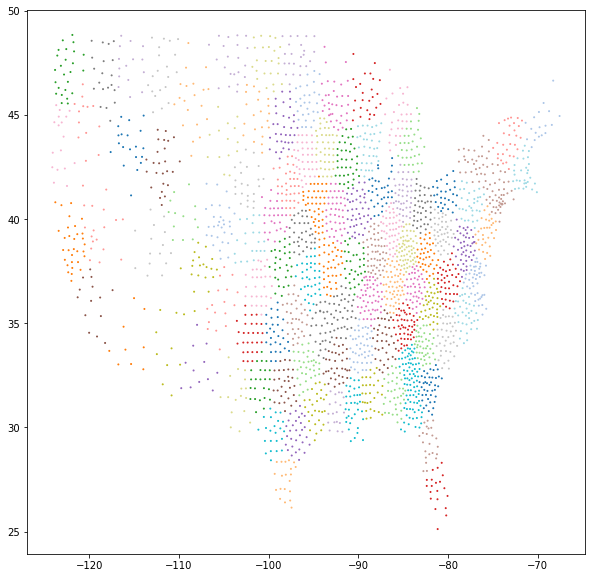

In [57]:
# Use KMeans to cluster geographically and then graph for a look
km_big = KMeans(n_clusters=300)
km_big.fit(geog_clus)
plt.figure(figsize=(10, 10))
plt.scatter(dri_model.longitude, dri_model.latitude, c=kmg.labels_, s=1, cmap="tab20");

Now, we can create a new dataframe with a new column showing the severity of the COVID mortality

In [58]:
big_risk = dri_low.drop(columns=(['population','death_risk_index',
                                  'state_name', 'positive_tests',
                                 'deaths']))

In [59]:
dri_low.columns


Index(['population', 'state_name', 'positive_tests', 'deaths', 'latitude',
       'longitude', 'deaths_per_100K', 'death_risk_index'],
      dtype='object')

In [60]:
big_risk.columns

Index(['latitude', 'longitude', 'deaths_per_100K'], dtype='object')

In [61]:
big_risk['cluster_num'] = km_big.labels_

In [62]:
big_risk.head()

,latitude,longitude,deaths_per_100K,cluster_num
county_state,,,,
"Autauga County, Alabama",32.536667,-86.648333,37.587929,297
"Baldwin County, Alabama",30.733056,-87.720278,9.855130,5
"Barbour County, Alabama",31.865833,-85.396111,20.254395,201
"Bibb County, Alabama",32.997778,-87.126389,8.930964,297
"Blount County, Alabama",33.966667,-86.583333,5.187978,269


In [63]:
big_risk.shape

(3014, 4)

In [64]:
type(big_risk.groupby('cluster_num').agg({'deaths_per_100K': 'mean'}))
                                      
# big_risk['Reg.Avg.Deaths_per_100K'] = 

pandas.core.frame.DataFrame

Now we need to add a column that corresponds with the cluster_num that shows the centroid of the cluster

In [65]:
death_map = {}
clus_map = big_risk.groupby('cluster_num')['deaths_per_100K'].mean()
for clus in range(len(clus_map)):
    death_map[clus] = clus_map[clus]

In [66]:
big_risk['Reg_Avg_Deaths_per_100K'] = big_risk.cluster_num.map(death_map)

In [67]:
big_risk['Reg_Avg_Deaths_per_100K']

county_state
Autauga County, Alabama       71.782637
Baldwin County, Alabama       32.510927
Barbour County, Alabama       70.990128
Bibb County, Alabama          71.782637
Blount County, Alabama        25.398360
                                ...    
Sweetwater County, Wyoming     7.548475
Teton County, Wyoming          2.130924
Uinta County, Wyoming          1.829223
Washakie County, Wyoming      20.977951
Weston County, Wyoming         0.539479
Name: Reg_Avg_Deaths_per_100K, Length: 3014, dtype: float64

In [68]:
big_risk.columns

Index(['latitude', 'longitude', 'deaths_per_100K', 'cluster_num',
       'Reg_Avg_Deaths_per_100K'],
      dtype='object')

It turns out that this big_risk dataframe contains over 3,000 rows, and each county here is clustered in to one of 300 groups that then have an averaged deaths per 100K.  This leads to a watering down of some problem counties in rural areas and an exacerbation of the high density areas such as New York City and Norther New Jersey when it comes to a heatmap of the deaths per capita, which can be misleading.  The same will happen if we only use 300 cluster centers.

In [69]:
big_risk.to_csv(path_to_home+path_to_data+'big_covid_clusters.csv')

In [70]:
#sns.heatmap(resulting.hotspot)

In [71]:
# This is not working on my machine
# !pip install geopandas
# import geopandas as gpd

In [72]:
big_risk.shape

(3014, 5)

In [73]:
big_risk.groupby('cluster_num')

Now we need the cluster centers for each of the 300 new clusters in order to better map them with their average deaths per 100K

In [74]:
death_map.values

<function dict.values>

In [75]:
# It turns out that this code ends up entering a list of ALL of the keys and values in 
# every row of the dataframe.  That was not the intent, we want one key and one value
# on each row.
#death_zones_df = pd.DataFrame({'zone': death_map.keys(), 
#                               'avg_deaths_per_100K': death_map.values()})

In [77]:
death_zones_df = pd.DataFrame.from_dict(data=death_map, orient='index')

In [78]:
death_zones_df.shape

(300, 1)

In [79]:
death_zones_df.head()

,0
0,21.626617
1,7.124252
2,53.412711
3,14.044098
4,5.792602


In [80]:
death_zones_df.rename(columns={0: 'avg_reg_deaths_per_100K'}, inplace=True)
death_zones_df.head()

,avg_reg_deaths_per_100K
0,21.626617
1,7.124252
2,53.412711
3,14.044098
4,5.792602


In [81]:
km_big.cluster_centers_[0][1]

-76.89285714285714

In [82]:
c_lats = []
c_lons = []

for i in range(len(km_big.cluster_centers_)):
    c_lats.append(km_big.cluster_centers_[i][0])
    c_lons.append(km_big.cluster_centers_[i][1])
    
#km_big.cluster_centers_[death_zones_df.index][0]

In [83]:
death_zones_df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            290, 291, 292, 293, 294, 295, 296, 297, 298, 299],
           dtype='int64', length=300)

In [84]:
death_zones_df['latitude'] = c_lats
death_zones_df['longitude'] = c_lons

In [85]:
c_lats[:10]

[40.760714285714286,
 39.75833333333333,
 39.678333333333335,
 36.91532983838382,
 39.83428571428571,
 31.034845679012445,
 45.60727272727273,
 33.849,
 31.336370370444467,
 33.560303030303004]

In [86]:
death_zones_df[250:270]

,avg_reg_deaths_per_100K,latitude,longitude
250,12.780426,48.140000,-94.305000
251,9.853484,32.640909,-95.248182
252,60.622386,41.643042,-71.000375
253,6.187514,46.076250,-97.692500
254,4.891950,39.328148,-79.294074
255,10.368270,43.817879,-91.133106
256,112.906151,39.860714,-74.974286
257,10.449458,39.598462,-90.380000
258,59.491760,33.675625,-113.235347
259,0.000000,46.082124,-112.987492


In [87]:
death_zones_df.to_csv(path_to_home+path_to_data+'death_zones.csv')

## Now run a set of models to do multi-class classification

In [88]:
resulting.drop(columns='state_name', inplace=True)


In [89]:
resulting.dtypes

population          float64
positive_tests      float64
deaths              float64
latitude            float64
longitude           float64
deaths_per_100K     float64
death_risk_index    float64
cluster             float64
hotspot             float64
dtype: object

In [90]:
resulting.describe().T

,count,mean,std,min,25%,50%,75%,max
population,6034.0,105864.454093,338943.616321,404.000000,11361.000000,26234.000000,68072.750000,1.003911e+07
positive_tests,6034.0,1467.915479,6624.309515,1.000000,51.250000,186.000000,665.000000,1.884810e+05
deaths,6034.0,48.409513,268.228960,0.000000,0.000000,3.000000,15.000000,5.934000e+03
latitude,6034.0,38.280764,4.882185,19.583333,34.640000,38.360000,41.700000,6.121833e+01
longitude,6034.0,-91.806890,11.625700,-159.650000,-97.996667,-90.260000,-83.500000,-6.755033e+01
deaths_per_100K,6034.0,23.935341,38.569056,0.000000,0.000000,9.787609,29.770606,4.020338e+02
death_risk_index,6034.0,2060.226060,8054.918501,0.000000,0.000000,95.797288,886.288998,1.616312e+05
cluster,3014.0,49.671865,28.952944,0.000000,24.000000,51.000000,74.000000,9.900000e+01
hotspot,3014.0,0.697412,0.869141,0.000000,0.000000,1.000000,1.000000,4.000000e+00


In [91]:
resulting.to_csv(path_to_home+path_to_data+'covid-resulting-dataframe.csv')

In [92]:
# #This can be run 
# features = ['population', 'positive_tests', 'deaths', 'deaths_per_100K', 'hotspot']
# #X = resulting.drop(columns=['hotspot', 'longitude', 'latitude'])

# X = resulting[features]
# y = resulting.hotspot
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
# lr = LogisticRegression()

# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X)

# lr.fit(X_train, y_train)
# print("Training Score: ", lr.score(X_train, y_train))
# print("Testing Score: ", lr.score(X_test, y_test))

In [93]:
gs = GridSearchCV


## Look at new data including hospitalizations

According to the New York Times as of July 21, the White House was not deceminating the county-level data for total hospitalizations. 

## Recreate the whole pipeline on a timeseries dataset